# Transfer learning with TF part 3 Scaling up
we've seen the power of transfer learning feature extration and fine-tuning, Now its time to scale up to all the classes in 101 food (total 101 classes of foods) 

Our goal is to beat the original food101 paper with 10% of the training (leverage the power of deep learning)

Oue baseline to beat is 50.76% accuracy across 101 classes  

In [1]:
!nvidia-smi

Sun Jul  4 06:58:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget = https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-04 06:58:19--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2021-07-04 06:58:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-04 06:58:19 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]

FINISHED --2021-07-04 06:58:19--
Total wall clock time: 0.07s
Downloaded: 1 files, 10K in 0s (109 MB/s)


In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
### 101 food classes: working with less data
!wget = https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-07-04 06:58:25--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2021-07-04 06:58:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   127MB/s    in 7.5s    

2021-07-04 06:58:32 (205 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

FINISHED --2021-07-04 06:58:32--
Total wall clock time: 7.7s
Downloaded: 1 files, 1.5G in 7.5s (205 MB/s)


In [5]:
unzip_data('/content/101_food_classes_10_percent.zip')

In [6]:
walk_through_dir('/content/101_food_classes_10_percent')

There are 2 directories and 0 images in '/content/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 image

In [8]:
train_dir = '/content/101_food_classes_10_percent/train'
test_dir = '/content/101_food_classes_10_percent/test'

In [9]:
#setup data input
import tensorflow as tf
batch_size = 32
img_size = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=img_size
                                                                                )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=img_size,
                                                                shuffle=False) # dont want to shufle for pred analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with Transfer learning on 10 percent of 101 food classes

here are the steps we are going to take
* create ModelCheckpoint callbacks
* create a data augmentation layer to build data augmentation right into the model
* Build a headless (No top layers) Functional EfficientNetB0 backboned-model (we'll create our owm output layer )
* compile a model
* feature extract for 5 full passes (5 epoch on the train data set, validation on 15% of the test data, to save epoch time)

In [10]:
# create checkpoint callback
checkpoint_path =  '/content/101_classes_10_percent_model_checkpoint'
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weight_only=True,
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [11]:
# data augmentation 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale(1/255.) # rescale input of images between 0 nad 1 required for a model like resnet 
], name='data_augmenation')

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

 # setup the base model and freeze its layers (this will extract feature)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

 # setup model architecture
inputs =  layers.Input(shape=(224,224,3), name='input_layer')  
x= data_augmentation(inputs)
x = base_model(x, training=False) # put the base model so weights need to stay frozen 
x = layers.GlobalAveragePooling2D(name='global_average_layers')(x)
output = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, output)

16711680/16705208 [==============================] - 0s 0us/step


In [13]:
model.summary( )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmenation (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_layers (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [15]:
history_1 = model.fit(train_data_all_10_percent,
                      epochs=5,
                      validation_data = test_data,
                      validation_steps=(0.15 *  len(test_data)),
                      callbacks = [checkpoint_callbacks]
                      )

Epoch 1/5
237/237 [==============================] - 120s 359ms/step - loss: 3.4599 - accuracy: 0.2531 - val_loss: 2.6885 - val_accuracy: 0.3855


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/101_classes_10_percent_model_checkpoint/assets
Epoch 2/5
237/237 [==============================] - 70s 295ms/step - loss: 2.3420 - accuracy: 0.4589 - val_loss: 2.2495 - val_accuracy: 0.4540


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/101_classes_10_percent_model_checkpoint/assets
Epoch 3/5
237/237 [==============================] - 63s 263ms/step - loss: 1.9713 - accuracy: 0.5296 - val_loss: 2.0590 - val_accuracy: 0.4790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/101_classes_10_percent_model_checkpoint/assets
Epoch 4/5
237/237 [==============================] - 62s 261ms/step - loss: 1.7607 - accuracy: 0.5678 - val_loss: 1.9936 - val_accuracy: 0.4869


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/101_classes_10_percent_model_checkpoint/assets
Epoch 5/5
237/237 [==============================] - 57s 240ms/step - loss: 1.5991 - accuracy: 0.6086 - val_loss: 1.9148 - val_accuracy: 0.5047


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/101_classes_10_percent_model_checkpoint/assets


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmenation (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_layers (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


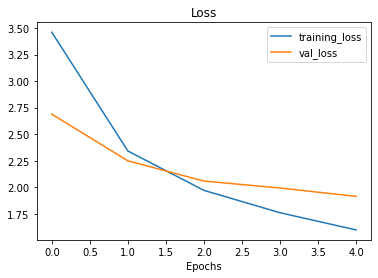

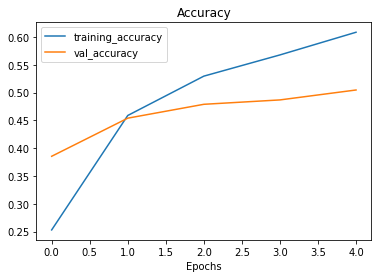

In [17]:
plot_loss_curves(history_1)

In [18]:
model_1_eval = model.evaluate(test_data)

790/790 [==============================] - 88s 111ms/step - loss: 1.7102 - accuracy: 0.5530


# what do these curves suggest? Hint:
Ideally, the two curves should be very close to each other, it not it may suggest that our models is overfitting (performing to well on training data and not generalize on test data)

### Fine tuning

In [19]:
# unfreeze all of the layer in base model
base_model.trainable = True

#refreeze every layer except last 5
for layers in base_model.layers[:-5]:
  layers.trainable = False 

In [20]:
# recompile the model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),# by 10x lower the lr
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
# what layer in the model are trainable
for layers in model.layers:
  print(layers.name, layers.trainable)

input_layer True
data_augmenation True
efficientnetb0 True
global_average_layers True
output_layer True


In [26]:
for layers_num, layer in enumerate(model.layers[2].layers):
  print(layers_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [28]:
# Fine Tune last 5 layer
fine_tune_epoch = 10 # model has already done 5 epoch (feature extraction), this is the total num of epoch

#fine tune our model
history_all_fine_tune = model.fit(train_data_all_10_percent,
                                  epochs=fine_tune_epoch,
                                  validation_data = test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  initial_epoch=history_1.epoch[-1])


Epoch 5/10
237/237 [==============================] - 65s 248ms/step - loss: 1.3650 - accuracy: 0.6511 - val_loss: 1.8982 - val_accuracy: 0.4992
Epoch 6/10
237/237 [==============================] - 54s 227ms/step - loss: 1.2319 - accuracy: 0.6756 - val_loss: 1.8887 - val_accuracy: 0.5048
Epoch 7/10
237/237 [==============================] - 53s 223ms/step - loss: 1.1622 - accuracy: 0.6947 - val_loss: 1.8682 - val_accuracy: 0.5159
Epoch 8/10
237/237 [==============================] - 51s 216ms/step - loss: 1.0853 - accuracy: 0.7179 - val_loss: 1.8834 - val_accuracy: 0.5119
Epoch 9/10
237/237 [==============================] - 50s 208ms/step - loss: 1.0343 - accuracy: 0.7257 - val_loss: 1.8669 - val_accuracy: 0.5188
Epoch 10/10
237/237 [==============================] - 50s 207ms/step - loss: 0.9661 - accuracy: 0.7411 - val_loss: 1.9334 - val_accuracy: 0.5077


In [29]:
history_fine_tune = model.evaluate(test_data)

790/790 [==============================] - 86s 109ms/step - loss: 1.6251 - accuracy: 0.5760


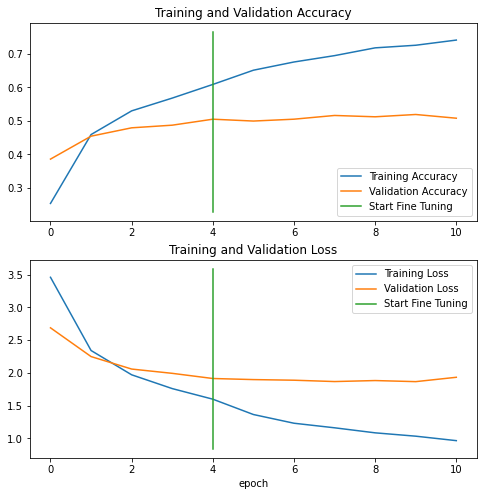

In [37]:
#compare the history of two model
compare_historys(history_1,
                history_all_fine_tune,
                initial_epochs = 5 )

### Saving and loading our models

In [38]:
# save our fine tune model on google drive
model.save('/content/drive/MyDrive/tensorflow_course/101_food_classes_10_per_fine_tune_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/101_food_classes_10_per_fine_tune_model/assets


In [41]:
# load and evaluate save model
load_model = tf.keras.models.load_model('/content/drive/MyDrive/tensorflow_course/101_food_classes_10_per_fine_tune_model')

In [42]:
load_model = load_model.evaluate(test_data)

790/790 [==============================] - 92s 115ms/step - loss: 1.6251 - accuracy: 0.5760


In [43]:
load_model

[1.6250920295715332, 0.5759999752044678]

 # evaluate the performance of big dog model across diffe classes
 visualize them and then later find out which prediction were the `most` wrong

In [44]:
import tensorflow as tf

# download pre-trained model (one that we prepare earlier, so all prediction are similar)
!wget = https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-07-04 08:03:36--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2021-07-04 08:03:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.135.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  67.9MB/s    in 0.7s    

2021-07-04 08:03:37 (67.9 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]

FINISHED --2021-07-04 08:03:37--
Total wall clock time: 0.9s
Downloaded: 1 files, 45M in 0.7s (67.9 MB/s)


In [45]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [47]:
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [48]:
# evaluate loaded model (the one we just downlaod on test data)
result_download_model = model.evaluate(test_data)

790/790 [==============================] - 89s 111ms/step - loss: 1.8027 - accuracy: 0.6078


In [50]:
result_download_model

[1.8027206659317017, 0.6077623963356018]

In [51]:
# making predition with our train model
preds_probs = model.predict(test_data, verbose=1) # set verbose to see how long is left


790/790 [==============================] - 60s 75ms/step


In [52]:
# how many pred are there
len(preds_probs)

25250

In [53]:
# what the shape of our prediction
preds_probs.shape

(25250, 101)

In [54]:
# lets see 1st 10 predictio look like
preds_probs[:10]

array([[5.9542239e-02, 3.5742103e-06, 4.1377019e-02, ..., 1.4138755e-09,
        8.3530882e-05, 3.0897513e-03],
       [9.6401668e-01, 1.3753297e-09, 8.4780651e-04, ..., 5.4287142e-05,
        7.8362646e-12, 9.8466391e-10],
       [9.5925868e-01, 3.2533582e-05, 1.4866963e-03, ..., 7.1891134e-07,
        5.4397265e-07, 4.0275925e-05],
       ...,
       [4.7313195e-01, 1.2931216e-07, 1.4805621e-03, ..., 5.9750048e-04,
        6.6968998e-05, 2.3469287e-05],
       [4.4571981e-02, 4.7265297e-07, 1.2258506e-01, ..., 6.3498560e-06,
        7.5318289e-06, 3.6778618e-03],
       [7.2438973e-01, 1.9249775e-09, 5.2311101e-05, ..., 1.2291376e-03,
        1.5792748e-09, 9.6395757e-05]], dtype=float32)

In [59]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95422387e-02, 3.57421027e-06, 4.13770191e-02, 1.06605913e-09,
        8.16142443e-09, 8.66397887e-09, 8.09271683e-07, 8.56525446e-07,
        1.98590260e-05, 8.09776509e-07, 3.17279114e-09, 9.86738769e-07,
        2.85322982e-04, 7.80491616e-10, 7.42302334e-04, 3.89164379e-05,
        6.47404613e-06, 2.49772938e-06, 3.78912264e-05, 2.06783199e-07,
        1.55384296e-05, 8.15071473e-07, 2.62305571e-06, 2.00106768e-07,
        8.38274900e-07, 5.42161160e-06, 3.73910166e-06, 1.31505766e-08,
        2.77615129e-03, 2.80519071e-05, 6.85625168e-10, 2.55748437e-05,
        1.66889222e-04, 7.64071084e-10, 4.04529186e-04, 1.31506281e-08,
        1.79574204e-06, 1.44481965e-06, 2.30629221e-02, 8.24668177e-07,
        8.53656502e-07, 1.71386205e-06, 7.05252751e-06, 1.84021580e-08,
        2.85534156e-07, 7.94834159e-06, 2.06816048e-06, 1.85251793e-07,
        3.36197559e-08, 3.15225538e-04, 1.04109376e-05, 8.54485734e-07,
        8.47418308e-01, 1.05554609e-05, 4.40946053e-07, 3.740423

In [63]:
# we got one prediction probability per classes (in our case thats is 101 classes)
print(f"highest probabilt for sample 0: {preds_probs[0].argmax()}")

highest probabilt for sample 0: 52


In [64]:
test_data.class_names[52]

'gyoza'

In [67]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [68]:
len(pred_classes)

25250

In [70]:
# test_data.class_names[pred_classes]

In [77]:
# to get out test labels we need to unravel our test_data batch
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [78]:
# how many y_labels are there
len(y_labels)

25250

In [87]:
class_names = test_data.class_names

In [88]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

 # evaluate model prediction
 one way to check our model prediction array is in the same order as our test data labels array is to find the accuracy score.

In [79]:
from sklearn.metrics import accuracy_score
sklearn_aacuarcy = accuracy_score(y_labels, pred_classes)

In [80]:
sklearn_aacuarcy

0.6077623762376237

In [82]:
result_download_model[1]

0.6077623963356018

In [83]:
import numpy as np
np.isclose(result_download_model[1], sklearn_aacuarcy)

True

## Scikit learn has a helpful function for acquiring many different classification metrics per class (precision recall f1score)

In [84]:
 from sklearn.metrics import classification_report
 print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

A numbers above give a great class-by-class evaluation of our models prediction but so many classe quite hard to understand

How about we create a visualization to get a better understanding

In [85]:
# get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

# lets plot all of the classes F1-score

In [89]:
# create empty dictionary 
class_f1_score = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_score[class_names[int(k)]] = v['f1-score']
class_f1_score 

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [91]:
import pandas as pd
f1_score = pd.DataFrame({'class-names': list(class_f1_score.keys()),
                         'f1-score': list(class_f1_score.values())}).sort_values("f1-score", ascending=False)

In [92]:
f1_score

,class-names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


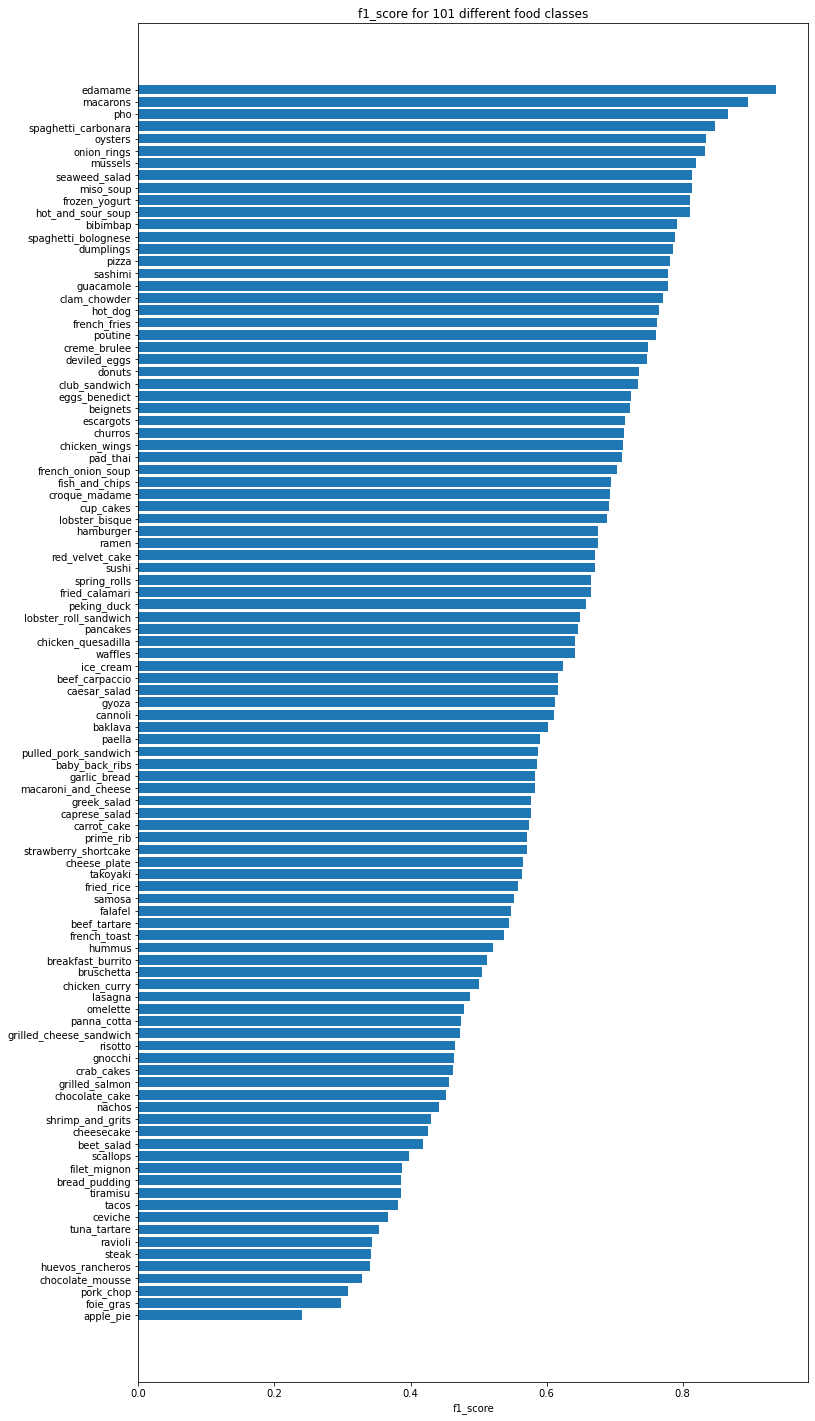

In [100]:
import matplotlib.pyplot as plt
fig, ax  = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_score)), f1_score['f1-score'].values)
ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score['class-names'])
ax.set_xlabel('f1_score')
ax.set_title('f1_score for 101 different food classes')
ax.invert_yaxis();

### To visualize our models  prediction on our own image, we will need a function to load and preprocessing images
1. read in a target image filepath using tf.io.read_file()
2. turn images into tensor using tf.io.decode_image()
3. resize the image tensor to be the same size as the images our models has trained on using tf.image.resize()
4. rescale the to get all of the pixel values between 0 and 1 (if necessary )

In [101]:
def load_and_prep(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # resize the img
  img = tf.image.resize(img, [img_shape, img_shape])

  # scale yes/no 
  if scale:
    # rescale the img between 0 and 1
    return img/255.
  else:
    return img



375889.jpg
/content/101_food_classes_10_percent/test/cheesecake/375889.jpg
1011328.jpg
/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg
1150148.jpg
/content/101_food_classes_10_percent/test/ravioli/1150148.jpg


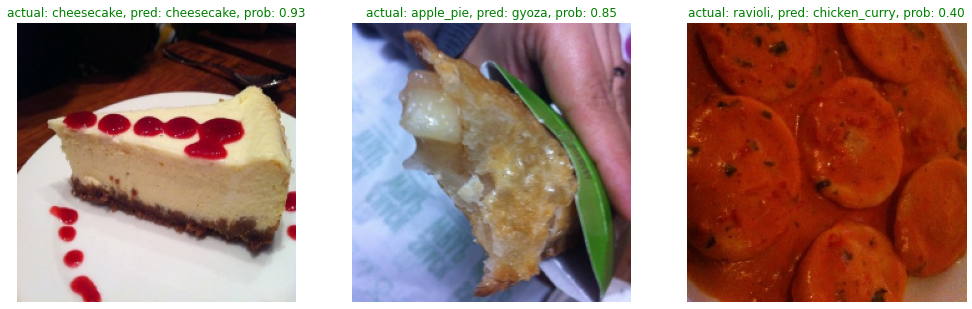

In [116]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  print(filename)
  filepath = test_dir + '/' + class_name + '/' + filename
  print(filepath)

  # load the images and make predictio
  img = load_and_prep(filename=filepath, scale=False)
  img_extended = tf.expand_dims(img, axis=0)
  preds_prob = model.predict(img_extended) # get prediction probability arrays
  preds_class = class_names[preds_prob.argmax()] # get highest prediction probability index
  # print(preds_class)

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == preds_class:
    title_color = 'g'
  else:
    tile_color = 'r'
  plt.title(f"actual: {class_name}, pred: {preds_class}, prob: {preds_prob.max():.2f}", c=title_color)
  plt.axis(False);
